In [ ]:
# Use seaborn for pairplot
!pip install seaborn

# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-fu2scals
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-fu2scals
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0da14bed189bacc104c76ef11d64f9f986fdbff9d_-cp36-none-any.whl size=115561 sha256=24898ae702f4fe3f2991f30690c77a5fe371164bdca0413192e2379eab2488fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-cbzent7d/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import io 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0


In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [ ]:
#Loading cvs file with dataset
from google.colab import files
data_to_load = files.upload()

Saving vgsales.csv to vgsales.csv


In [ ]:
#Converting csv to dataset
raw_dataset = pd.read_csv(io.BytesIO(data_to_load['vgsales.csv']),
                      na_values = "?", comment='\t',
                      sep=",")

dataset = raw_dataset.copy()
dataset.tail()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.0,0.0,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.0,0.0,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.0,0.0,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.0,0.0,0.01
16597,16600,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.0,0.0,0.01


In [ ]:
dataset.isna().sum()

In [ ]:
#Preparing data set
dataset = dataset.dropna()
dataset = dataset.drop(['Rank'], axis=1)
dataset = dataset.drop(['Name'], axis=1)
dataset = dataset.drop(['EU_Sales'], axis =1 )
dataset = dataset.drop(['JP_Sales'], axis=1)
dataset = dataset.drop(['Other_Sales'], axis=1)

#Drop all rows with 0 sales
dataset= dataset.drop(dataset[dataset['Global_Sales'] == 0.00].index)

In [ ]:
#Convert categorical values to numbers
dataset['Platform'] = pd.factorize(dataset['Platform'] )[0] 
dataset['Genre'] = pd.factorize(dataset['Genre'] )[0]
dataset['Publisher'] = pd.factorize(dataset['Publisher'] )[0]
dataset['Year'] = pd.factorize(dataset['Year'] )[0]


,Platform,Year,Genre,Publisher,NA_Sales,Global_Sales
0,0,0,0,0,41.49,82.74
1,1,1,1,0,29.08,40.24
2,0,2,2,0,15.85,35.82
3,0,3,0,0,15.75,33.00
4,2,4,3,0,11.27,31.37
...,...,...,...,...,...,...
16593,8,15,1,186,0.01,0.01
16594,18,27,6,51,0.01,0.01
16595,6,2,2,4,0.00,0.01
16596,3,10,4,505,0.00,0.01


In [ ]:
#Separate dataset to training and test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
sns.pairplot(train_dataset[["Platform", "Year", "Genre", "NA_Sales"]], diag_kind="kde")

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("Global_Sales")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Platform,13033.0,8.621192,5.896936,0.0,4.0,6.00,13.00,30.00
Year,13033.0,12.683342,8.756012,0.0,4.0,11.00,19.00,38.00
Genre,13033.0,5.275838,3.423228,0.0,2.0,6.00,8.00,11.00
Publisher,13033.0,60.966700,101.047275,0.0,7.0,19.00,57.00,575.00
NA_Sales,13033.0,0.262122,0.779143,0.0,0.0,0.08,0.24,29.08


In [ ]:
# Removing item of prediction from data set
train_labels = train_dataset.pop('Global_Sales')
test_labels = test_dataset.pop('Global_Sales')

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
#creating a model 
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 8,833
Trainable params: 8,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 50
import time
start = time.time()

#Model trainig  with predefined properties
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, # validation_split is used for evaluation during training of model
  callbacks=[tfdocs.modeling.EpochDots()])

end = time.time()
print(end - start)



Epoch: 0, loss:0.1992,  mae:0.1843,  mse:0.1992,  val_loss:0.2811,  val_mae:0.1865,  val_mse:0.2811,  
..................................................43.07909417152405


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
45,0.193619,0.183908,0.193619,0.204921,0.171656,0.204921,45
46,0.199420,0.184638,0.199420,0.180656,0.181048,0.180656,46
47,0.200284,0.184305,0.200284,0.230878,0.180264,0.230878,47
48,0.191855,0.184617,0.191855,0.261359,0.181169,0.261359,48
49,0.188891,0.183112,0.188891,0.243357,0.172073,0.243357,49


In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

(0.0, 0.5)

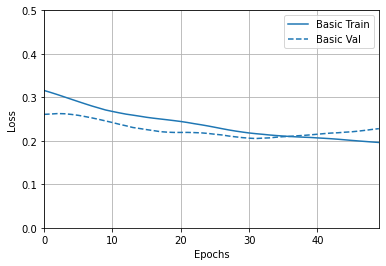

In [ ]:
plotter.plot({'Basic': history}, metric = "loss")
plt.ylim([0, 0.5])

Text(0, 0.5, 'MAE [Global Sales/Mil.]')

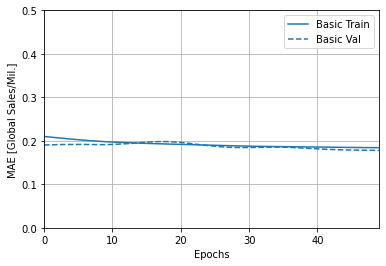

In [ ]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 0.5])
plt.ylabel('MAE [Global Sales/Mil.]')

Text(0, 0.5, 'MSE [Global Sales/Mil.^2]')

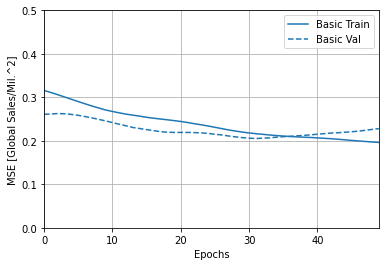

In [ ]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 0.5])
plt.ylabel('MSE [Global Sales/Mil.^2]')

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Mil.".format(mae))

102/102 - 0s - loss: 0.5333 - mae: 0.1965 - mse: 0.5333
Testing set Mean Abs Error:  0.20 Mil.


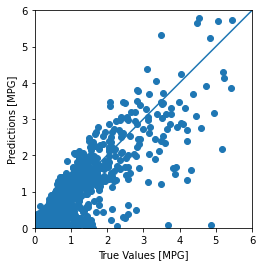

In [ ]:
#Prediction with testing dataset
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 6]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

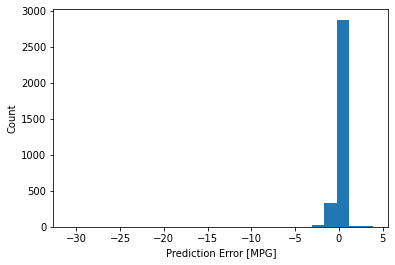

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")